NOTE: inside jupyter notebook is better to plot images with matplotlib instead of cv2

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

# Task 2 - Fourier Transform

In [2]:
def get_convolution(image, kernel):
    kernel = np.flipud(np.fliplr(kernel))  # Flip kernel for convolution vertically and horizentally 
    output = np.zeros_like(image)  # Output array
    padded_image = np.pad(image, [(kernel.shape[0]//2,)]*2, mode='constant') #The padding allows the kernel to be applied without running out of bounds at the image edges
    #the size is half of kernel for each side. 
    
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            output[i, j] = np.sum(kernel * padded_image[i:i+kernel.shape[0], j:j+kernel.shape[1]]) #For each region of padded image, an element-wise multiplication with kernel is used --> they are summed in the end. 
    return output

In [3]:
def get_convolution_using_fourier_transform(image, kernel):
    # Matching kernel size with image size for FFT 
    kernel_padded = np.pad(kernel, [(0, image.shape[0] - kernel.shape[0]), (0, image.shape[1] - kernel.shape[1])], 'constant')
    
    # Compute FFT of image and kernel
    fft_image = np.fft.fft2(image)
    fft_kernel = np.fft.fft2(kernel_padded, s=image.shape)
    
    # Perform element-wise multiplication in frequency domain and inverse FFT
    return np.abs(np.fft.ifft2(fft_image * fft_kernel))


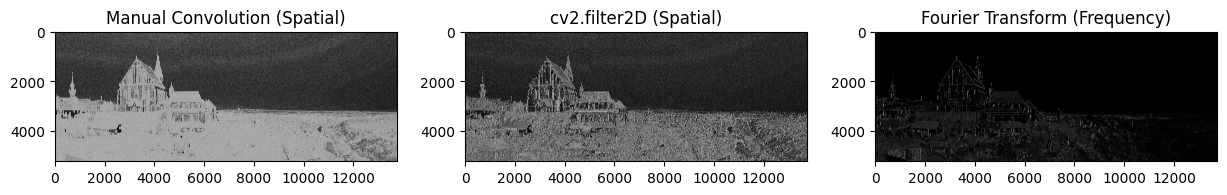

Manual Convolution Time: 1276.2526 seconds
cv2.filter2D Time: 1.4955 seconds
Fourier Transform Convolution Time: 65.3299 seconds
Mean Absolute Difference (Manual vs cv2): 3.3711
Mean Absolute Difference (Manual vs FFT): 38.8916
Mean Absolute Difference (cv2 vs FFT): 40.5903


In [4]:
# Load image
image = cv2.imread("./data/oldtown.jpg", cv2.IMREAD_GRAYSCALE)
#Sobel Filter 
# using Gx_ij = i / (i*i + j*j)
#Gy_ij = j / (i*i + j*j)
kernelx = np.array([
    [-3/18, -2/13, -1/10, 0, 1/10, 2/13, 3/18],
    [-3/13, -2/8,  -1/5,  0, 1/5,  2/8,  3/13],
    [-3/10, -2/5,  -1/2,  0, 1/2,  2/5,  3/10],
    [-3/9,  -2/4,  -1/1,  0, 1/1,  2/4,  3/9 ],
    [-3/10, -2/5,  -1/2,  0, 1/2,  2/5,  3/10],
    [-3/13, -2/8,  -1/5,  0, 1/5,  2/8,  3/13],
    [-3/18, -2/13, -1/10, 0, 1/10, 2/13, 3/18]
])

kernely = kernelx.T
 #applying both horizentally and vertically 
start_time = time.time()
conv_result_x = get_convolution(image, kernelx)
conv_result_y = get_convolution(image, kernely)
conv_result = np.sqrt(conv_result_x**2 + conv_result_y**2)
conv_time = time.time() - start_time

start_time = time.time()
cv_result_x = cv2.filter2D(image, -1, kernelx)
cv_result_y = cv2.filter2D(image, -1, kernely)
cv_result = np.sqrt(cv_result_x**2 + cv_result_y**2)
cv_time = time.time() - start_time

start_time = time.time()
fft_result_x = get_convolution_using_fourier_transform(image, kernelx)
fft_result_y = get_convolution_using_fourier_transform(image, kernely)
fft_result = np.sqrt(fft_result_x**2 + fft_result_y**2)
fft_time = time.time() - start_time

mad_manual_cv2 = np.mean(np.abs(conv_result - cv_result))
mad_manual_fft = np.mean(np.abs(conv_result - fft_result))
mad_cv2_fft = np.mean(np.abs(cv_result - fft_result))

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(conv_result, cmap='gray')
plt.title("Manual Convolution (Spatial)")

plt.subplot(1, 3, 2)
plt.imshow(cv_result, cmap='gray')
plt.title("cv2.filter2D (Spatial)")

plt.subplot(1, 3, 3)
plt.imshow(fft_result, cmap='gray')
plt.title("Fourier Transform (Frequency)")

plt.show()

# Display time and mean absolute difference results
print(f"Manual Convolution Time: {conv_time:.4f} seconds")
print(f"cv2.filter2D Time: {cv_time:.4f} seconds")
print(f"Fourier Transform Convolution Time: {fft_time:.4f} seconds")
print(f"Mean Absolute Difference (Manual vs cv2): {mad_manual_cv2:.4f}")
print(f"Mean Absolute Difference (Manual vs FFT): {mad_manual_fft:.4f}")
print(f"Mean Absolute Difference (cv2 vs FFT): {mad_cv2_fft:.4f}")


# Task 3 - Template Matching

In [5]:
def normalized_cross_correlation(image, template):
    H, W = image.shape
    h, w = template.shape
    res_h, res_w = (H-h+1, W-w+1) # Output image size
    
    ncc_matrix = np.zeros((res_h, res_w))
    
    template_mean_diff = template - np.mean(template)
    template_squared_sum = np.sum(template_mean_diff**2)
    
    for height in range(res_h):
        for width in range(res_w):
            f = image[height:height+h, width:width+w]
            f_mean_diff = f - np.mean(f)
            ncc_matrix[height, width] = np.sum(template_mean_diff*f_mean_diff) / (np.sqrt(template_squared_sum*np.sum(f_mean_diff**2)))
            
    return ncc_matrix
    
    

def ssd(image, template):
    H, W = image.shape
    h, w = template.shape
    res_h, res_w = (H-h+1, W-w+1) # Output image size
    
    ssd_matrix = np.zeros((res_h, res_w))
    for height in range(res_h):
        for width in range(res_w):
            f = image[height:height+h, width:width+w]
            # Normalized on purpose, so that values are not too large for matching using instructed values (0.1)
            ssd_matrix[height, width] = np.sum((template-f)**2) / np.sqrt(np.sum(template**2)*np.sum(f**2))
            
    return ssd_matrix


def draw_rectangle_at_matches(image, template_h, template_w, matches):
    for row in range(matches.shape[0]):
        for col in range(matches.shape[1]):
            if matches[row, col]:
                cv2.rectangle(image, (col, row), (col + template_w, row + template_h), 1.0, 2)
    return image
    

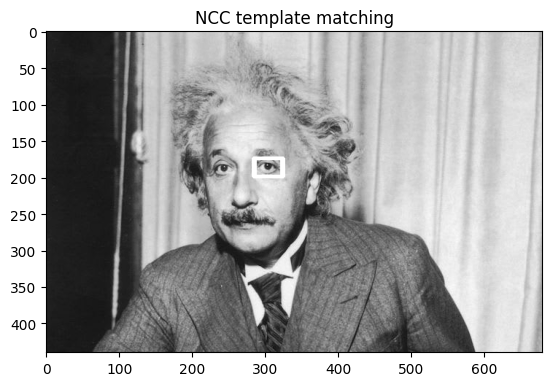

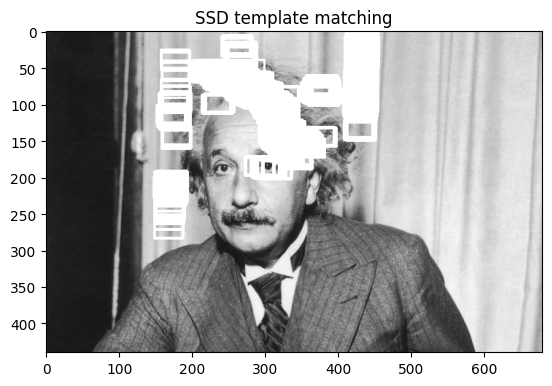

In [6]:
# Load images
image = cv2.imread("./data/einstein.jpeg", cv2.IMREAD_GRAYSCALE)
template = cv2.imread("./data/einstein_eye.jpeg", cv2.IMREAD_GRAYSCALE)

# convert to float and apply intensity transformation to image
image = image.astype(np.float32)
template = template.astype(np.float32)
image = cv2.normalize(
    image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
template = cv2.normalize(
    template, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)


# NCC
image_ncc = image.copy()
result_ncc = normalized_cross_correlation(image_ncc, template)
matches_ncc = np.where(result_ncc >= 0.7, 1, 0)
rectangled_ncc = draw_rectangle_at_matches(image_ncc, template.shape[0], template.shape[1], matches_ncc)
plt.title("NCC template matching")
plt.imshow(rectangled_ncc, cmap="gray")
plt.show()

# SSD
image_ssd = image.copy()
result_ssd = ssd(image_ssd, template)
matches_ssd = np.where(result_ssd <=0.1, 1, 0)
rectangled_ssd = draw_rectangle_at_matches(image_ssd, template.shape[0], template.shape[1], matches_ssd)
plt.title("SSD template matching")
plt.imshow(rectangled_ssd, cmap="gray")
plt.show()


In [7]:
# Without normalizing SSD minimum value in the matrix is still greater than threshold value 0.1 ~0.61
# With normalizing SSD minimum value in the matrix is 0.0014; by further decreasing threshold value it is possible
# to obtain the rectangle (and overlook the noises) that matches the template
result_ssd.min()

0.0014026827411726117

/var/folders/l4/jfvbkqp14fd8m7dlf36rj__r0000gn/T/ipykernel_1977/4153186652.py:15: RuntimeWarning: invalid value encountered in scalar divide
  ncc_matrix[height, width] = np.sum(template_mean_diff*f_mean_diff) / (np.sqrt(template_squared_sum*np.sum(f_mean_diff**2)))


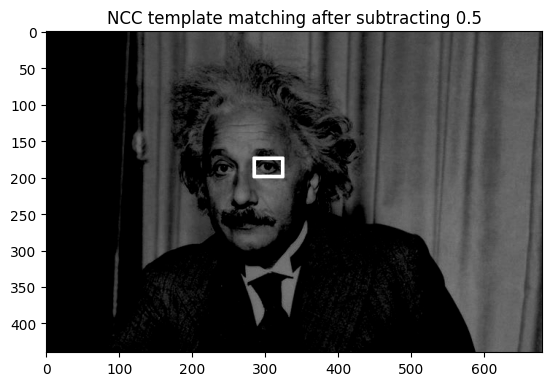

/var/folders/l4/jfvbkqp14fd8m7dlf36rj__r0000gn/T/ipykernel_1977/4153186652.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  ssd_matrix[height, width] = np.sum((template-f)**2) / np.sqrt(np.sum(template**2)*np.sum(f**2))


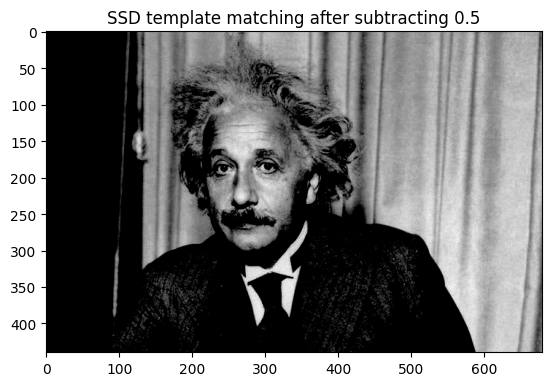

In [8]:
subtracted_image = np.clip(image - 0.5, 0, None)

# NCC
image_ncc = subtracted_image.copy()
result_ncc = normalized_cross_correlation(image_ncc, template)
matches_ncc = np.where(result_ncc >= 0.7, 1, 0)
rectangled_ncc = draw_rectangle_at_matches(image_ncc, template.shape[0], template.shape[1], matches_ncc)
plt.title("NCC template matching after subtracting 0.5")
plt.imshow(rectangled_ncc, cmap="gray")
plt.show()


# SSD
image_ssd = subtracted_image.copy()
result_ssd = ssd(image_ssd, template)
matches_ssd = np.where(result_ssd <=0.1, 1, 0)
rectangled_ssd = draw_rectangle_at_matches(image_ssd, template.shape[0], template.shape[1], matches_ssd)
plt.title("SSD template matching after subtracting 0.5")
plt.imshow(rectangled_ssd, cmap="gray")
plt.show()

In [9]:
(image_ssd==image_ncc).all()

False

# Task 4 - Gaussian Pyramid

In [10]:
def build_gaussian_pyramid_opencv(image, num_levels):
    image_copy = image.copy()
    pyramids = [image_copy]
    for i in range(1, num_levels): # Starting from level 1
        # OpenCV's function
        image_copy = cv2.pyrDown(image_copy)
        pyramids.append(image_copy)
    return pyramids
    

def build_gaussian_pyramid(image, num_levels):
    image_copy = image.copy()
    pyramids = [image_copy]
    for i in range(1, num_levels): # Starting from level 1
        # Apply Gaussian filter
        blurred = cv2.GaussianBlur(pyramids[-1], (5, 5), sigmaX=1)
        # Scale down by taking every second pixel
        downsampled = blurred[::2, ::2]
        pyramids.append(downsampled)
    return pyramids


def normalized_cross_correlation(image, template):
    H, W = image.shape
    h, w = template.shape
    res_h, res_w = (H-h+1, W-w+1) # Output image size
    
    ncc_matrix = np.zeros((res_h, res_w))
    
    template_mean_diff = template - np.mean(template)
    template_squared_sum = np.sum(template_mean_diff**2)
    
    for height in range(res_h):
        for width in range(res_w):
            f = image[height:height+h, width:width+w]
            f_mean_diff = f - np.mean(f)
            ncc_matrix[height, width] = np.sum(template_mean_diff*f_mean_diff) / (np.sqrt(template_squared_sum*np.sum(f_mean_diff**2)))
            
    return ncc_matrix


def template_matching_multiple_scales(image_pyramid, template_pyramid):
    best_matches = []
    ncc_matrices = []
    
    for level, (image_level, template_level) in enumerate(zip(image_pyramid[1:], template_pyramid[1:])): # Start from level 1, as level 0 is original NCC template matching
        ncc_matrix = normalized_cross_correlation(image_level, template_level)
        ncc_matrices.append(ncc_matrix)
    return ncc_matrices
    
    

In [11]:
# Load images
image = cv2.imread("./data/traffic.jpg", cv2.IMREAD_GRAYSCALE)
template = cv2.imread("./data/traffic-template.png", cv2.IMREAD_GRAYSCALE)
template_h, template_w = template.shape

cv_pyramid = build_gaussian_pyramid_opencv(image, 4)
my_pyramid = build_gaussian_pyramid(image, 4)
my_pyramid_template = build_gaussian_pyramid(template, 4)


# Compare and print mean absolute difference at each level
for l in range(4):
    absolute_difference = np.abs(cv_pyramid[l] - my_pyramid[l])
    mean_absolute_difference = np.mean(absolute_difference)
    print(f"Mean Absolute Difference for level {l}:", mean_absolute_difference)
    

# Calculate the time needed for template matching without the pyramid
start_time = time.time()
result_ncc = normalized_cross_correlation(image, template)
end_time = time.time()
print(f"Time taken for template matching using NCC: {end_time-start_time} seconds")


# Calculate the time needed for template matching with the pyramid from Level 1 using NCC
start_time = time.time()
result = template_matching_multiple_scales(my_pyramid, my_pyramid_template)
end_time = time.time()
print(f"Time taken for template matching with the pyramid: {end_time-start_time} seconds")



Mean Absolute Difference for level 0: 0.0
Mean Absolute Difference for level 1: 53.58657513786765
Mean Absolute Difference for level 2: 57.10356158088236
Mean Absolute Difference for level 3: 60.66167279411765
Time taken for template matching using NCC: 28.33615207672119 seconds
Time taken for template matching with the pyramid: 6.355309724807739 seconds


In [12]:
len(my_pyramid)

4

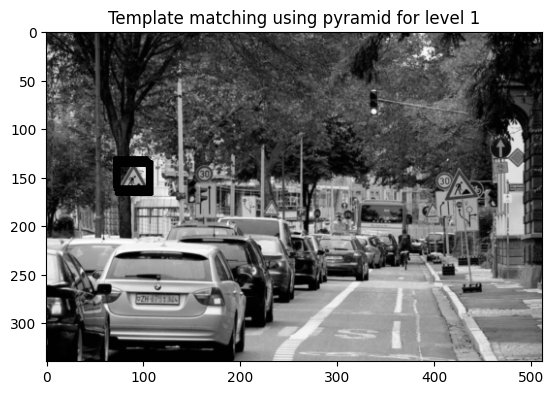

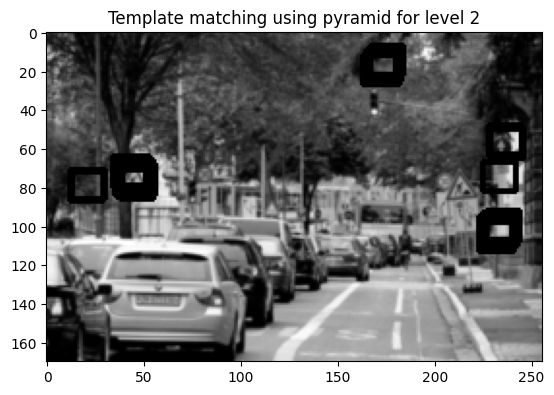

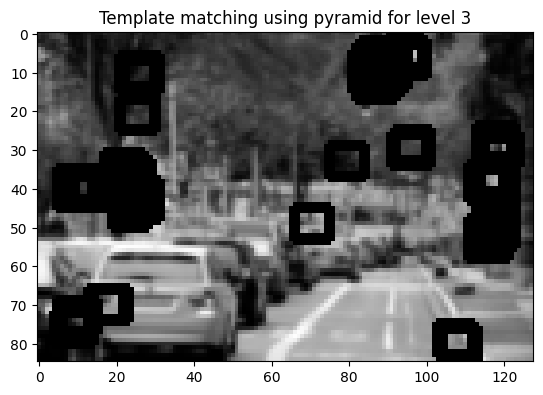

In [13]:
for i in range(3):
    image_copy = image.copy()
    result_pyramid = result[i]
    my_pyramid_level = my_pyramid[i+1].copy()
    my_pyramid_template_level = my_pyramid_template[i+1].copy()
    matches_pyramid = np.where(result_pyramid >= 0.7, 1, 0)
    rectangled_pyramid = draw_rectangle_at_matches(my_pyramid_level, my_pyramid_template_level.shape[0], my_pyramid_template_level.shape[1], matches_pyramid)
    plt.title(f"Template matching using pyramid for level {i+1}")
    plt.imshow(rectangled_pyramid, cmap="gray")
    plt.show()
    


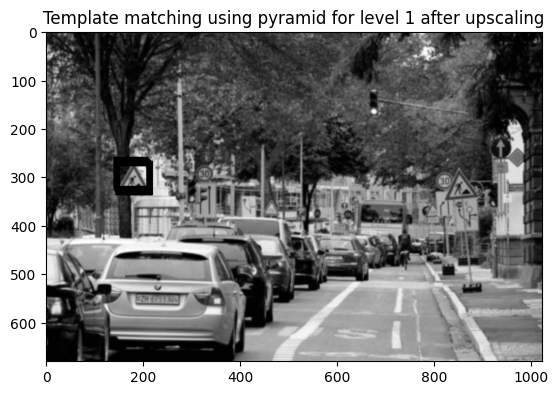

In [14]:
scaling_factor = 2
result_pyramid = result[0]
matches_pyramid = np.where(result_pyramid >= 0.7, 1, 0)
original_size_matches = (matches_pyramid.shape[1] * scaling_factor, matches_pyramid.shape[0] * scaling_factor)
resized_matches_pyramid = cv2.resize(matches_pyramid, original_size_matches, interpolation=cv2.INTER_NEAREST)


original_size_image = (my_pyramid[1].shape[1] * scaling_factor, my_pyramid[1].shape[0] * scaling_factor)
scaled_image = cv2.resize(my_pyramid[1], original_size_image, interpolation=cv2.INTER_LINEAR)
original_size_template = (my_pyramid_template[1].shape[1] * scaling_factor, my_pyramid_template[1].shape[0] * scaling_factor)
scaled_template = cv2.resize(my_pyramid_template[1], original_size_template, interpolation=cv2.INTER_LINEAR)


rectangled_pyramid_upscaled = draw_rectangle_at_matches(scaled_image, scaled_template.shape[0], scaled_template.shape[1], resized_matches_pyramid)
plt.title(f"Template matching using pyramid for level 1 after upscaling")
plt.imshow(rectangled_pyramid_upscaled, cmap="gray")
plt.show()


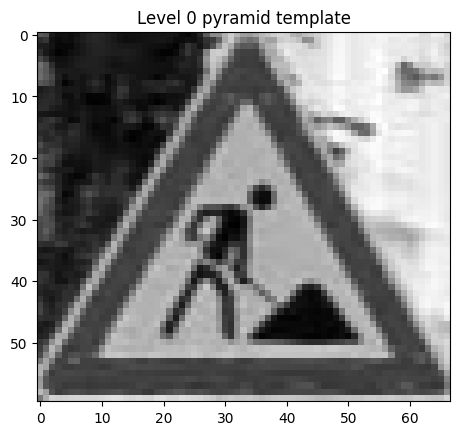

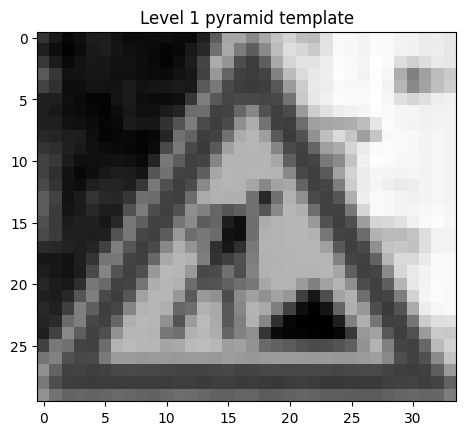

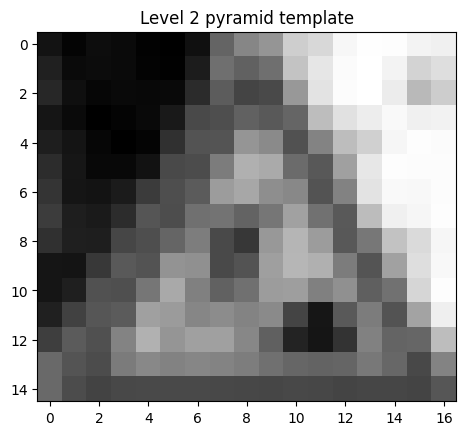

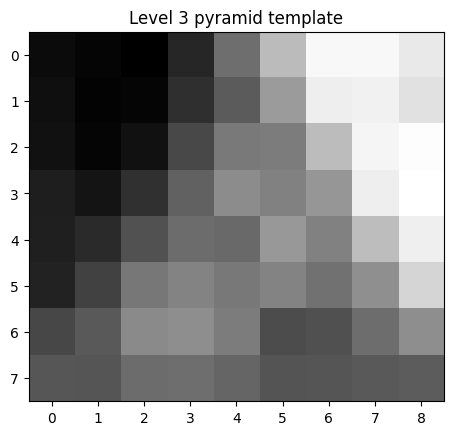

In [15]:
for i in range(4):
    plt.title(f"Level {i} pyramid template")
    plt.imshow(my_pyramid_template[i], cmap="gray")
    plt.show()

# Task 5 - Blending Regions

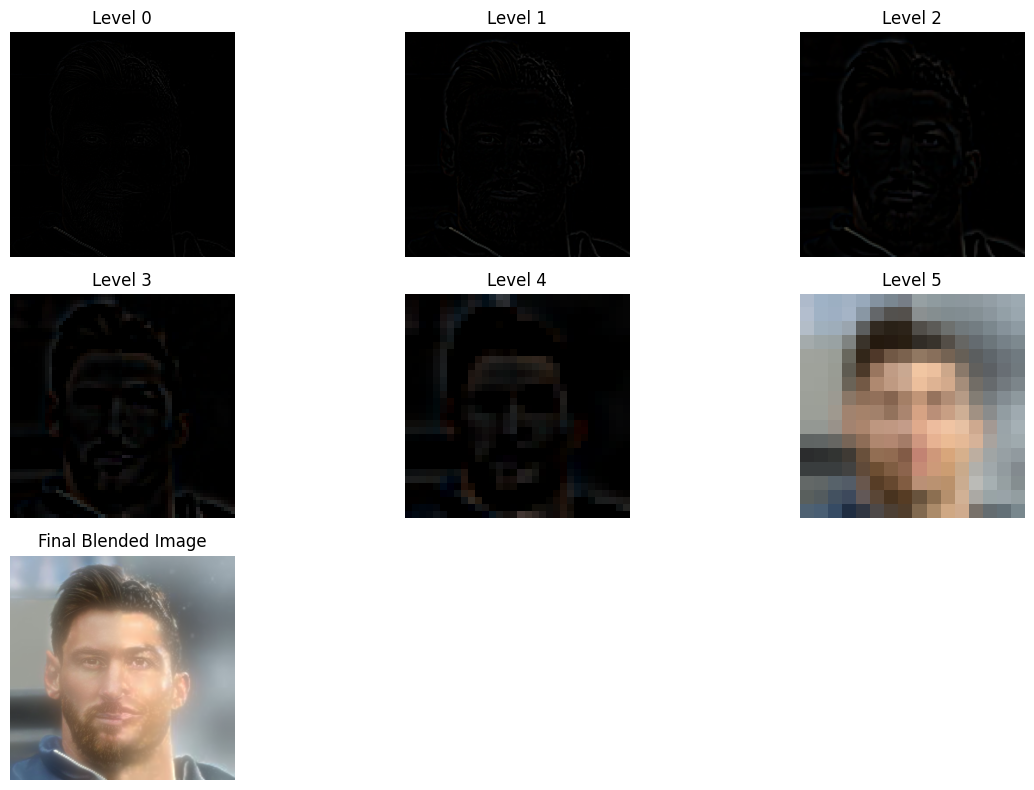

In [16]:
# Load images
messi = cv2.imread('data/messi.jpg')
ronaldo = cv2.imread('data/ronaldo.jpeg')

#creating a specified number of levels in the pyramid, where each subsequent level is a lower-resolution version of the previous one with pyrdown

def build_gaussian_pyramid(image, levels):
    gaussian_pyramid = [image]
    for _ in range(levels):
        image = cv2.pyrDown(image)
        gaussian_pyramid.append(image)
    return gaussian_pyramid

#Creating a Laplacian pyramid by computing the difference between each level of the Gaussian pyramid and an upscaled version of the next level


def build_laplacian_pyramid(gaussian_pyramid):
    laplacian_pyramid = []
    for i in range(len(gaussian_pyramid) - 1):
        gaussian_expanded = cv2.pyrUp(gaussian_pyramid[i + 1])
        laplacian = cv2.subtract(gaussian_pyramid[i], gaussian_expanded)
        laplacian_pyramid.append(laplacian)
    laplacian_pyramid.append(gaussian_pyramid[-1])  # Last level is the same
    return laplacian_pyramid

#The combined Laplacian pyramid stores these halves merged together to create a blended effect
def combine_laplacian_pyramids(laplacian1, laplacian2):
    combined = []
    for l1, l2 in zip(laplacian1, laplacian2):
        # Combine the left half of l1 with the right half of l2
        rows, cols, _ = l1.shape
        combined_lap = np.hstack((l1[:, :cols // 2], l2[:, cols // 2:]))
        combined.append(combined_lap)
    return combined

#reconstructing the final blended image by expanding each level in the combined Laplacian pyramid back up to the original resolution

def collapse_pyramid(combined_pyramid):
    image = combined_pyramid[-1]
    for i in range(len(combined_pyramid) - 2, -1, -1):
        image = cv2.pyrUp(image)
        image = cv2.add(combined_pyramid[i], image)
    return image
messi = cv2.resize(messi, (512, 512))
ronaldo = cv2.resize(ronaldo, (512, 512))

# Build Gaussian pyramids
levels = 5
gaussian_messi = build_gaussian_pyramid(messi, levels)
gaussian_ronaldo = build_gaussian_pyramid(ronaldo, levels)

# Build Laplacian pyramids
laplacian_messi = build_laplacian_pyramid(gaussian_messi)
laplacian_ronaldo = build_laplacian_pyramid(gaussian_ronaldo)

# Combine the Laplacian pyramids
combined_laplacian = combine_laplacian_pyramids(laplacian_messi, laplacian_ronaldo)

# Collapse the combined pyramid
blended_image = collapse_pyramid(combined_laplacian)

# Plotting the results
plt.figure(figsize=(12, 8))
for i, layer in enumerate(combined_laplacian):
    plt.subplot(3, 3, i + 1)
    plt.imshow(cv2.cvtColor(layer, cv2.COLOR_BGR2RGB))
    plt.title(f'Level {i}')
    plt.axis('off')

plt.subplot(3, 3, len(combined_laplacian) + 1)
plt.imshow(cv2.cvtColor(blended_image, cv2.COLOR_BGR2RGB))
plt.title('Final Blended Image')
plt.axis('off')

plt.tight_layout()
plt.show()